In [1]:
!pip install fitter
!pip install cryptocmd

     |████████████████████████████████| 47 kB 2.3 MB/s 
  Created wheel for fitter: filename=fitter-1.4.0-py3-none-any.whl size=25026 sha256=9480210d728259596124e3ca38e3bd039593ee78e74a46987c3b117a8744ffb3
  Stored in directory: /root/.cache/pip/wheels/e1/98/16/e5263962f94fbfaad79902aa94652516caccc1f1d51509e853
  Created wheel for easydev: filename=easydev-0.12.0-py3-none-any.whl size=64232 sha256=45a2b2faf00870a8f215564352dd210ccb54a98f5c319e5fc95e97d9837d17be
  Stored in directory: /root/.cache/pip/wheels/82/ab/83/fdfc4017ea44a585b6754752cc5f63f2d0d63fcc1317e7174b
Successfully built fitter easydev
     |████████████████████████████████| 48 kB 1.6 MB/s 


In [ ]:
import os
from functools import reduce
import random

# Data Processing
import numpy as np
import pandas as pd
import datetime as dt

import seaborn as sns
import matplotlib.pyplot as plt
# !pip install fitter
from fitter import Fitter, get_common_distributions, get_distributions

# api for web scraping coinmarketcap
from cryptocmd import CmcScraper

# crypto api
from requests import Request, Session
from requests.exceptions import ConnectionError, Timeout, TooManyRedirects
import json

# get distributions from scipy
from scipy.stats import cauchy,chi2,expon,exponpow,gamma,lognorm,norm,powerlaw,rayleigh,uniform

In [ ]:
def plot_distributions(df):
  df_visual = df.replace(np.nan,0)

  if np.isinf(df).values.sum() > 0:
    df_visual.replace([np.inf, -np.inf], 0, inplace = True)

  fig, axes = plt.subplots(9,2, figsize = (20,50))
  row_num = 0

  for col in df.drop(columns = 'date').columns:
    sns.histplot(data = df_visual, x = col, ax = axes[row_num][0])
    sns.lineplot(data = df_visual, x = 'date', y = col, ax = axes[row_num][1])
    row_num += 1

In [ ]:
def find_best_distribution(df):
  best_dist = {}

  for col in df.drop('date',axis = 1).columns:
    f = Fitter(
        df[col].dropna().values,
        distributions = get_common_distributions(),
        bins = 200
    )

    f.fit()
    best_dist[col] = f.get_best(method= 'sumsquare_error')

  return best_dist

In [ ]:
def get_name_parameters(column):
  return next(iter(best_dist[column])), next(iter(best_dist[column].values()))

In [ ]:
get_common_distributions()

['cauchy',
 'chi2',
 'expon',
 'exponpow',
 'gamma',
 'lognorm',
 'norm',
 'powerlaw',
 'rayleigh',
 'uniform']

In [ ]:
'''cauchy,
 chi2,
 expon,
 exponpow,
 gamma,
 lognorm,
 norm,
 powerlaw,
 rayleigh,
 uniform'''

def cauchy_pdf(x, parameters):
  return cauchy.pdf(x = x, loc = parameters['loc'], scale = parameters['scale'])

def chi2_pdf(x, parameters, data):
  df = (data.shape[0]-1) * (data.shape[1]-1)
  return chi2.pdf(x = x, df = df, loc = parameters['loc'], scale = parameters['scale'])

def expon_pdf(x ,parameters):
  return expon.pdf(x = x, loc = parameters['loc'], scale = parameters['scale'])

def exponpow_pdf(x, parameters):
  return exponpow.pdf(x = x, b = parameters['b'], loc = parameters['loc'], scale = parameters['scale'])

def gamma_pdf(x, parameters):
  return gamma.pdf(x = x, a = parameters['a'], loc = parameters['loc'], scale = parameters['scale'])

def lognorm_pdf(x, parameters):
  return lognorm.pdf(x = x, s = parameters['s'], loc = parameters['loc'], scale = parameters['scale'])

def norm_pdf(x, parameters):
  return norm.pdf(x = x, loc = parameters['loc'], scale = parameters['scale'])

def powerlaw_pdf(x, parameters):
  return powerlaw.pdf(x = x, a = parameters['a'], loc = parameters['loc'], scale = parameters['scale'])

def rayleigh_pdf(x, parameters):
  return rayleigh.pdf(x = x, loc= parameters['loc'], scale = parameters['scale'])

def uniform_pdf(x, parameters):
  return uniform.pdf(x = x, loc = parameters['loc'], scale = parameters['scale'])

get_pdfs = {
    'cauchy':cauchy_pdf,
    'chi2':chi2_pdf,
    'expon':expon_pdf,
    'exponpow':exponpow_pdf,
    'gamma':gamma_pdf,
    'lognorm':lognorm_pdf,
    'norm':norm_pdf,
    'powerlaw':powerlaw_pdf,
    'rayleigh':rayleigh_pdf,
    'uniform':uniform_pdf
}


In [ ]:
url = 'https://pro-api.coinmarketcap.com/v1/cryptocurrency/listings/latest'
parameters = {
  'start':'1',
  'limit':'100',
  'convert':'USD',
  'sort':'market_cap',
  'sort_dir':'desc',
  'circulating_supply_max':'100000000000000000',
}
headers = {
  'Accepts': 'application/json',
  'X-CMC_PRO_API_KEY': '114eccc4-72b1-4540-8d65-dd998d202503',
}

session = Session()
session.headers.update(headers)

try:
  response = session.get(url, params=parameters)
  data = json.loads(response.text)
  print(data)
except (ConnectionError, Timeout, TooManyRedirects) as e:
  print(e)

{'status': {'timestamp': '2022-03-14T01:03:17.628Z', 'error_code': 0, 'error_message': None, 'elapsed': 88, 'credit_count': 1, 'notice': None, 'total_count': 9585}, 'data': [{'id': 1, 'name': 'Bitcoin', 'symbol': 'BTC', 'slug': 'bitcoin', 'num_market_pairs': 9232, 'date_added': '2013-04-28T00:00:00.000Z', 'tags': ['mineable', 'pow', 'sha-256', 'store-of-value', 'state-channel', 'coinbase-ventures-portfolio', 'three-arrows-capital-portfolio', 'polychain-capital-portfolio', 'binance-labs-portfolio', 'blockchain-capital-portfolio', 'boostvc-portfolio', 'cms-holdings-portfolio', 'dcg-portfolio', 'dragonfly-capital-portfolio', 'electric-capital-portfolio', 'fabric-ventures-portfolio', 'framework-ventures-portfolio', 'galaxy-digital-portfolio', 'huobi-capital-portfolio', 'alameda-research-portfolio', 'a16z-portfolio', '1confirmation-portfolio', 'winklevoss-capital-portfolio', 'usv-portfolio', 'placeholder-ventures-portfolio', 'pantera-capital-portfolio', 'multicoin-capital-portfolio', 'parad

In [ ]:
data

{'data': [{'circulating_supply': 18982612,
   'cmc_rank': 1,
   'date_added': '2013-04-28T00:00:00.000Z',
   'id': 1,
   'last_updated': '2022-03-14T01:02:00.000Z',
   'max_supply': 21000000,
   'name': 'Bitcoin',
   'num_market_pairs': 9232,
   'platform': None,
   'quote': {'USD': {'fully_diluted_market_cap': 795639697321.85,
     'last_updated': '2022-03-14T01:02:00.000Z',
     'market_cap': 719205698383.72,
     'market_cap_dominance': 42.4775,
     'percent_change_1h': 0.23203968,
     'percent_change_24h': -2.66627527,
     'percent_change_30d': -10.51560493,
     'percent_change_60d': -13.3699882,
     'percent_change_7d': -1.35139644,
     'percent_change_90d': -19.50015983,
     'price': 37887.60463437381,
     'volume_24h': 17721189486.602787,
     'volume_change_24h': 20.8174}},
   'self_reported_circulating_supply': None,
   'self_reported_market_cap': None,
   'slug': 'bitcoin',
   'symbol': 'BTC',
   'tags': ['mineable',
    'pow',
    'sha-256',
    'store-of-value',
   

In [ ]:
coin_name = {}
for i in range(5000):
  name = data['data'][i]['name']
  symbol = data['data'][i]['symbol']
  coin_name[name] = symbol

len(coin_name)

4985

In [ ]:
random_coin_name = random.sample(list(coin_name), 1)
random_coin_symbol = coin_name[random_coin_name[0]]
print(random_coin_name, random_coin_symbol)

['Hanzo'] HANZO


In [ ]:
# initialise scraper without time interval
scraper = CmcScraper(random_coin_symbol)

# get raw data as list of list
headers, data = scraper.get_data()

# get data in a json format
xrp_json_data = scraper.get_data("json")

# # export the data as csv file, you can also pass optional `name` parameter
# scraper.export("csv", name="bit_all_time")

# Pandas dataFrame for the same data
df = scraper.get_dataframe()

In [ ]:
df

,Date,Open,High,Low,Close,Volume,Market Cap
0,2022-03-13,2.704462e-08,2.826438e-08,2.112602e-08,2.641295e-08,62895.67,0
1,2022-03-12,2.650952e-08,3.010909e-08,2.092777e-08,2.704516e-08,72648.14,0
2,2022-03-11,2.479499e-08,2.954917e-08,2.015964e-08,2.650913e-08,65081.39,0
3,2022-03-10,3.012771e-08,3.012771e-08,2.169020e-08,2.479462e-08,76053.99,0
4,2022-03-09,2.111433e-08,3.014602e-08,1.917819e-08,3.012800e-08,71456.47,0
...,...,...,...,...,...,...,...
299,2021-05-17,2.400000e-07,4.500000e-07,2.300000e-07,4.000000e-07,1341105.48,0
300,2021-05-16,3.300000e-07,4.600000e-07,2.200000e-07,2.400000e-07,1715810.29,0
301,2021-05-15,4.600000e-07,7.200000e-07,3.300000e-07,3.400000e-07,2915464.95,0
302,2021-05-14,3.800000e-07,6.800000e-07,3.600000e-07,4.600000e-07,4365163.04,0


In [ ]:
df.drop(['Open','High','Low'], axis = 1, inplace = True)

df['close_24h'] = df['Close'].shift(periods = -1)
df['close_7d'] = df['Close'].shift(periods = -7)
df['close_30d'] = df['Close'].shift(periods = -30)
df['close_60d'] = df['Close'].shift(periods = -60)
df['close_90d'] = df['Close'].shift(periods = -90)
df['volume_24h'] = df['Volume'].shift(periods = -1)

df['%price_change_24h'] =   (  df['Close'] / df['close_24h'] - 1 ) * 100
df['%price_change_7d'] =  (  df['Close'] /  df['close_7d'] - 1 ) * 100
df['%price_change_30d'] =   (  df['Close'] / df['close_30d'] - 1 ) * 100
df['%price_change_60d'] =   (  df['Close'] / df['close_60d'] - 1 ) * 100
df['%price_change_90d'] =   (  df['Close'] / df['close_90d'] - 1 ) * 100
df['%volume_change_24h'] =   (df['Volume'] / df['volume_24h'] - 1 ) * 100

df.drop(['close_24h','close_7d','close_30d','close_60d','close_90d','volume_24h'], 
        axis = 1, inplace = True)
df.rename({'Close':'price'}, axis = 1, inplace = True)
df.columns = df.columns.str.lower()
df.fillna(0, inplace = True)

In [ ]:
print('inf',np.isinf(df).values.sum())
print('null',df.isnull().sum())

inf 2
null date                  0
price                 0
volume                0
market cap            0
%price_change_24h     0
%price_change_7d      0
%price_change_30d     0
%price_change_60d     0
%price_change_90d     0
%volume_change_24h    0
dtype: int64


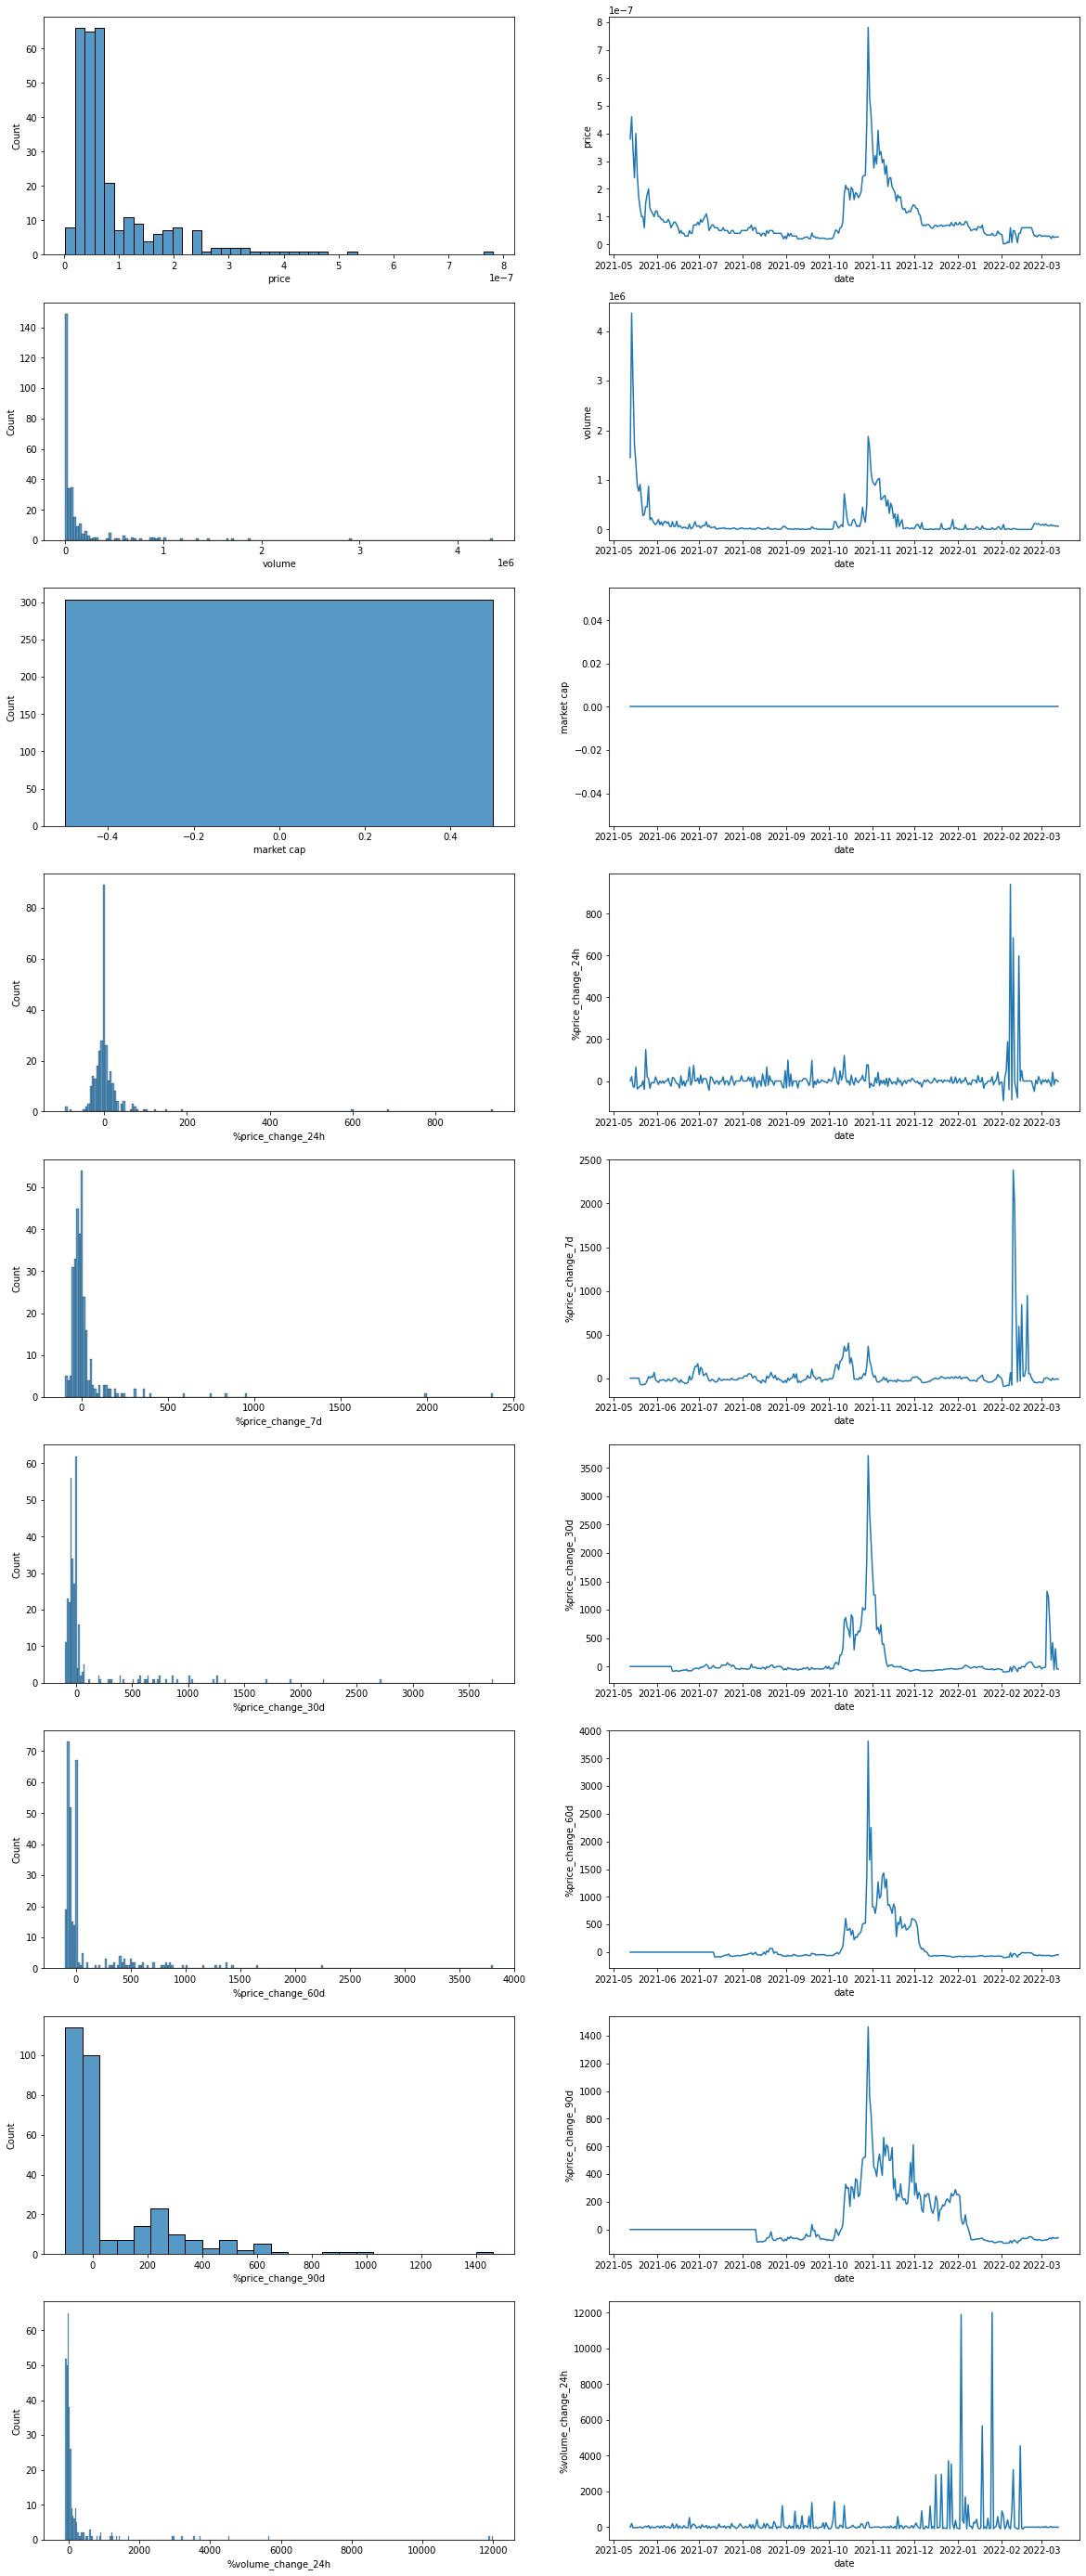

In [ ]:
plot_distributions(df)
plt.show()

In [ ]:
if np.isinf(df).values.sum() > 0:
  df_find = df.replace([np.inf, -np.inf], np.nan)
  best_dist = find_best_distribution(df_find)

else:
  best_dist = find_best_distribution(df)

In [ ]:
best_dist

{'%price_change_24h': {'cauchy': {'loc': -1.1210741018080337,
   'scale': 8.213652993625699}},
 '%price_change_30d': {'cauchy': {'loc': -28.857139873009203,
   'scale': 28.148460161119885}},
 '%price_change_60d': {'lognorm': {'loc': -99.32570606817615,
   's': 1.2448223179659934,
   'scale': 79.60328099324606}},
 '%price_change_7d': {'cauchy': {'loc': -12.431279158730295,
   'scale': 21.01211986862885}},
 '%price_change_90d': {'expon': {'loc': -99.43607154917495,
   'scale': 167.61712056609107}},
 '%volume_change_24h': {'cauchy': {'loc': -16.546649584159496,
   'scale': 48.57829925175477}},
 'market cap': {'exponpow': {'b': 0.12820523871161066,
   'loc': -8.41129344563595e-30,
   'scale': 0.9530620703276311}},
 'price': {'cauchy': {'loc': 5.165258216857906e-08,
   'scale': 2.2884970679708987e-08}},
 'volume': {'lognorm': {'loc': -81.34995174418574,
   's': 2.2163289292235717,
   'scale': 24758.789085499124}}}

In [ ]:
name1, params1 = get_name_parameters('%price_change_60d')

In [ ]:
# x = latest information from API
x = 0
result1 = get_pdfs[name1](x, params1)
result1

# get range of distribution
# normalize to 0-100 scale

0.003175961113583306

In [ ]:
# score_result = math.pow(result1,score)
# weight_result = math.pow(result1, weight)
# #average = (score_result+weight_result)/2

# final1 = score1...score6 = 0.5^6 = 0.016
# # final2 = weight1...weight6 = 
# # average = (final1+final2)/2
# # normalize average
# risk = 1 - average =0.984 98%